In [1]:
import sys
import os
import math
import random
import heapq 
import time
import copy
import gc
import numpy as np
import pandas as pd
from functools import reduce
from scipy.spatial.distance import pdist
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import faiss
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
torch.cuda.set_device(2)
print (torch.cuda.current_device())

Loading faiss with AVX2 support.


2


In [2]:
#Read data with List storage Name:[name],I:[img],Y[type]
def TypetoNum(itype): #map the type into number.
    if itype =='AMD': return 0
    elif itype =='DR': return 1
    elif itype =='glaucoma': return 2
    elif itype =='myopia': return 3
    else: return 4 #norm
    
root_dir = '/data/fjsdata/fundus/iSee/iSee_multi_dataset/' #the path of images
trainset = pd.read_csv("/data/fjsdata/fundus/iSee/iSee_multi_dataset/CBIR_iSee_train.csv" , sep=',')#load trainset
testset = pd.read_csv("/data/fjsdata/fundus/iSee/iSee_multi_dataset/CBIR_iSee_test.csv" , sep=',')#load testset
tstart = time.time()
#read train image with CV
trN, trI, trY = [],[],[]
norm = 6993
for iname, itype in np.array(trainset).tolist():
    if iname.endswith(".jpg"):
        try:
            image_dir = root_dir+'img_data_%s'%itype
            image_path = os.path.join(image_dir, iname)
            if itype == 'norm':
                if norm>0:
                    img = cv2.resize(cv2.imread(image_path).astype(np.float32), (512, 512))#(1920,1920,3)->(512,512,3)
                    trN.append(iname)
                    trI.append(img)
                    trY.append(TypetoNum(itype))
                    norm = norm - 1
            else:
                img = cv2.resize(cv2.imread(image_path).astype(np.float32), (512, 512))#(1920,1920,3)->(512,512,3)
                trN.append(iname)
                trI.append(img)
                trY.append(TypetoNum(itype))    
        except:
            print(iname+":"+str(image_path))
        sys.stdout.write('\r{} / {} '.format(len(trN),trainset.shape[0]))
        sys.stdout.flush()
print('The length of train set is %d'%len(trN))
#read test image with CV
teN, teI, teY = [],[],[]
norm = 777
for iname, itype in np.array(testset).tolist():
    if iname.endswith(".jpg"):
        try:
            image_dir = root_dir+'img_data_%s'%itype
            image_path = os.path.join(image_dir, iname)
            if itype == 'norm':
                if norm>0:
                    img = cv2.resize(cv2.imread(image_path).astype(np.float32), (512, 512))#(1920,1920,3)->(512,512,3)
                    teN.append(iname)
                    teI.append(img)
                    teY.append(TypetoNum(itype))
                    norm = norm - 1
            else:
                img = cv2.resize(cv2.imread(image_path).astype(np.float32), (512, 512))#(1920,1920,3)->(512,512,3)
                teN.append(iname)
                teI.append(img)
                teY.append(TypetoNum(itype)) 
        except:
            print(iname+":"+str(image_path))
        sys.stdout.write('\r{} / {} '.format(len(teN),testset.shape[0]))
        sys.stdout.flush()
print('The length of test set is %d'%len(teN))
elapsed = time.time() - tstart    
print('Completed buliding index in %d seconds' % int(elapsed))

#Generate image pairs for model
def onlineGenImgPairs(spls=len(trY)):
    idx_sf = random.sample(range(0, len(trY)),spls)
    trI1_sf, trI2_sf, trY1_sf, trY2_sf = [],[],[],[]
    flag = 0
    for i in idx_sf:
        if flag==0:
            trI1_sf.append(trI[i])
            trY1_sf.append(trY[i])
            flag =1
        else:
            trI2_sf.append(trI[i])
            trY2_sf.append(trY[i])
            flag =0
    trY_sf = np.where((np.array(trY1_sf)-np.array(trY2_sf))!=0,1,0)
    return np.array(trI1_sf),np.array(trI2_sf),trY_sf
trI1_sf, trI2_sf, trY_sf = onlineGenImgPairs()

9000 / 9000 The length of train set is 9000
1000 / 1000 The length of test set is 1000
Completed buliding index in 800 seconds


In [4]:
#feature map 
class SpatialAttention(nn.Module):#spatial attention layer
    def __init__(self):
        super(SpatialAttention, self).__init__()

        self.conv1 = nn.Conv2d(2, 1, kernel_size=3, padding=1, bias=False)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)
    
class ASHNet(nn.Module): #deep Hashint Network:DHNet
    def __init__(self,inChannels=3,outHashcode=16):
        super(ASHNet, self).__init__()
        #(channels, Height, Width)
        #layer1: Convolution, (3,512,512)->(16,256,256)
        self.conv1 = nn.Conv2d(in_channels=inChannels, out_channels=16, kernel_size=3, padding=1, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu1 = nn.ReLU(inplace=True)
        #layer2: max pooling,(16,256,256)->(16,128,128)
        self.maxpool = nn.MaxPool2d(kernel_size=3, padding=1, stride=2)
        self.bn2 = nn.BatchNorm2d(16)
        #layer3: Channel and Spatial Attention Layer, (8,256,256)->(8,256,256)
        self.sa = SpatialAttention()
        #layer4: Convolution, (16,128,128)->(32,64,64)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1, stride=2)
        self.bn3 = nn.BatchNorm2d(32)
        self.relu2 = nn.ReLU(inplace=True)
        #layer5: mean pooling, (32,64,64)->(32,32,32)
        self.avgpool = nn.AvgPool2d(kernel_size=3, padding=1, stride=2)
        self.bn4 = nn.BatchNorm2d(32)
        #layer6: fully connected, 32*32*32->4096
        self.fcl1 = nn.Linear(32*32*32,4096)
        self.relu3 = nn.ReLU(inplace=True)
        #layer7: Hashing layer, 4096->16
        self.fcl2 = nn.Linear(4096,outHashcode)
              
    def forward(self,x):
        #input: (batch_size, in_channels, Height, Width)
        #output: (batch_size, out_channels, Height, Width)
        #layer1: convolution
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        #layer2: max pooling
        x = self.maxpool(x)
        x = self.bn2(x)
        #layer3: Attention
        x = self.sa(x) * x  #spatial
        #layer4: Convolution
        x = self.conv2(x)
        x = self.bn3(x)
        x = self.relu2(x)
        #layer5: mean pooling
        x = self.avgpool(x)
        x = self.bn4(x)
        #layer6:fully connected layer
        x = x.view(x.size(0),-1) #transfer three dims to one dim
        x = self.fcl1(x)
        x = self.relu3(x)
        #layer7: Hashing layer
        x = self.fcl2(x)
                
        return x
    
#https://pytorch-cn.readthedocs.io/zh/latest/    
#https://github.com/filipradenovic/cnnimageretrieval-pytorch/blob/master/cirtorch/layers/functional.py
class HashLossFunc(nn.Module):
    def __init__(self, margin=0.5, alpha=0.01):
        super(HashLossFunc, self).__init__()
        self.alpha = alpha #regularization
        self.margin = margin #margin threshold
        self.mse_loss = nn.MSELoss(reduction='none')
        self.l1_loss = nn.L1Loss(reduction='mean')
    
    def forward(self,h1,h2,y):    
        margin_val = self.margin * h1.shape[1]
        squared_loss = torch.mean(self.mse_loss(h1, h2), dim=1)
        # T1: 0.5 * (1 - y) * dist(x1, x2)
        positive_pair_loss = (0.5 * (1 - y) * squared_loss)
        mean_positive_pair_loss = torch.mean(positive_pair_loss)
        # T2: 0.5 * y * max(margin - dist(x1, x2), 0)
        zeros = torch.zeros_like(squared_loss)
        marginMat = margin_val * torch.ones_like(squared_loss)
        negative_pair_loss = 0.5 * y * torch.max(zeros, marginMat - squared_loss)
        mean_negative_pair_loss = torch.mean(negative_pair_loss)

        # T3: alpha(dst_l1(abs(x1), 1)) + dist_l1(abs(x2), 1)))
        mean_value_regularization = self.alpha * (
                self.l1_loss(torch.abs(h1), torch.ones_like(h1)) +
                self.l1_loss(torch.abs(h2), torch.ones_like(h2)))

        loss = mean_positive_pair_loss + mean_negative_pair_loss + mean_value_regularization
        return loss
    
#define model
model = ASHNet(outHashcode=12).cuda()#[12,24,36,48]
criterion  = HashLossFunc(margin=0.5).cuda() #define loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #define optimizer
#train model
best_net, best_loss = None, float('inf')
batchSize = 10
for epoch in range(10):#iteration
    #trI1_sf, trI2_sf, trY_sf = onlineGenImgPairs()
    losses = []
    num_batches = len(trY_sf) // batchSize
    for i in range(num_batches):
        optimizer.zero_grad()#grad vanish
        min_idx = i * batchSize
        max_idx = np.min([len(trY_sf), (i+1)*batchSize])
        I1_batch = torch.from_numpy(trI1_sf[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        I2_batch = torch.from_numpy(trI2_sf[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        Y_batch = torch.from_numpy(trY_sf[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        #forword
        X1_batch = model(I1_batch.permute(0, 3, 1, 2))#permute the dims of matrix
        X2_batch = model(I2_batch.permute(0, 3, 1, 2))
        #binary-like loss
        loss = criterion(X1_batch,X2_batch,Y_batch)
        #backward
        loss.backward()
        #update parameters
        optimizer.step()
        #show loss
        sys.stdout.write('\r {} / {} : loss = {}'.format(i+1, num_batches, float('%0.6f'%loss.item())))
        sys.stdout.flush()     
        losses.append(loss.item())
    print("Eopch: %5d mean_loss = %.6f" % (epoch + 1, np.mean(losses)))
    if np.mean(losses) < best_loss:
        best_loss = np.mean(losses)
        best_net = copy.deepcopy(model)
print("best_loss = %.6f" % (best_loss))
#release gpu memory
model = model.cpu()
loss = loss.cpu()
torch.cuda.empty_cache()

 450 / 450 : loss = 1.802036Eopch:     1 mean_loss = 1.548573
 450 / 450 : loss = 1.801496Eopch:     2 mean_loss = 1.176677
 450 / 450 : loss = 1.800117Eopch:     3 mean_loss = 1.154725
 450 / 450 : loss = 1.811517Eopch:     4 mean_loss = 1.157703
 450 / 450 : loss = 1.800383Eopch:     5 mean_loss = 1.154513
 450 / 450 : loss = 1.800442Eopch:     6 mean_loss = 1.153947
 450 / 450 : loss = 1.800415Eopch:     7 mean_loss = 1.154001
 450 / 450 : loss = 1.800408Eopch:     8 mean_loss = 1.157049
 450 / 450 : loss = 1.800145Eopch:     9 mean_loss = 1.153885
 450 / 450 : loss = 1.800014Eopch:    10 mean_loss = 1.153792
best_loss = 1.153792


/data/fjsdata/fundus/iSee/iSee_multi_dataset/img_data_glaucoma/912777.jpg


(-0.5, 1941.5, 1919.5, -0.5)

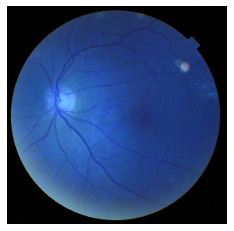

In [71]:
# Visualize feature maps
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

# normalizing the output
def normalize_output(img):
    img = img - img.min()
    img = img / img.max()
    return img

#original
#original
root_dir = '/data/fjsdata/fundus/iSee/iSee_multi_dataset/'
image_path = os.path.join(root_dir+'img_data_glaucoma', teN[131])
print(image_path)
#img = cv2.imread(image_path,cv2.IMREAD_GRAYSCALE)
oriImg = cv2.imread(image_path)
#oriImg = normalize_output(oriImg)
#oriImg = cv2.applyColorMap(oriImg, cv2.COLORMAP_JET)
plt.imshow(oriImg)
plt.axis('off')

(-0.5, 1941.5, 1919.5, -0.5)

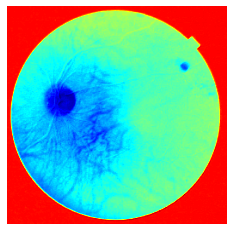

In [72]:
#train
data = torch.from_numpy(np.array(teI[131:132])).type(torch.FloatTensor).cuda()
output = best_net(data.permute(0, 3, 1, 2))#forword
#conv1         
best_net.conv1.register_forward_hook(get_activation('conv1'))#maxpool
feature = activation['conv1'].squeeze()
feature_0 = feature[0].cpu().numpy()
feature_0 = normalize_output(feature_0)
feature_0 = np.uint8(255 * feature_0)
#plot
height, width, _ = oriImg.shape
featuremap = cv2.applyColorMap(cv2.resize(feature_0,(width, height)), cv2.COLORMAP_JET)
#featuremap = featuremap * 0.3 + oriImg * 0.5
plt.imshow(featuremap)
plt.axis('off')

(-0.5, 1941.5, 1919.5, -0.5)

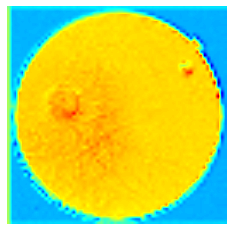

In [73]:
#conv2         
best_net.conv2.register_forward_hook(get_activation('conv2'))#maxpool
feature = activation['conv2'].squeeze()
feature_0 = feature[0].cpu().numpy()
feature_0 = normalize_output(feature_0)
feature_0 = np.uint8(255 * feature_0)
#plot
height, width, _ = oriImg.shape
featuremap = cv2.applyColorMap(cv2.resize(feature_0,(width, height)), cv2.COLORMAP_JET)
#featuremap = featuremap * 0.3 + oriImg * 0.5
plt.imshow(featuremap)
plt.axis('off')

In [5]:
class SpatialAttention(nn.Module):#spatial attention layer
    def __init__(self):
        super(SpatialAttention, self).__init__()

        self.conv1 = nn.Conv2d(2, 1, kernel_size=3, padding=1, bias=False)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)
    
class ResBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, stride=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels, out_channels=out_channels,
                kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
        )

        self.downsample_layer = None
        self.do_downsample = False
        if in_channels != out_channels or stride != 1:
            self.do_downsample = True
            self.downsample_layer = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 3, stride, 1, bias=False),
                nn.BatchNorm2d(out_channels),
            )

        # initialize weights
        self.apply(self.init_weights)

    def forward(self, x):
        identity = x
        out = self.net(x)

        if self.do_downsample:
            identity = self.downsample_layer(x)

        return F.relu(out + identity, inplace=True)

    @staticmethod
    def init_weights(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)
            
class ASHResNet(nn.Module):
    def __init__(self, code_size: int):
        super().__init__()
        #Resnet
        self.net = nn.Sequential(
            ResBlock(in_channels=3, out_channels=16),
            ResBlock(in_channels=16, out_channels=16),
            ResBlock(in_channels=16, out_channels=16, stride=2),
        ) 
        #Attention 
        self.sa = SpatialAttention() 
        #fully connected
        self.linear = nn.Linear(16*256*256, code_size)

        # initialize weights
        self.apply(self.init_weights)

    def forward(self, x):
        x = self.net(x)
        x = self.sa(x)*x
        x = x.view(x.size(0),-1)
        x = self.linear(x)
        return x

    @staticmethod
    def init_weights(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)
    
class HashLossFunc(nn.Module):
    def __init__(self, margin=0.5, alpha=0.01):
        super(HashLossFunc, self).__init__()
        self.alpha = alpha #regularization
        self.margin = margin #margin threshold
        self.mse_loss = nn.MSELoss(reduction='none')
        self.l1_loss = nn.L1Loss(reduction='mean')
    
    def forward(self,h1,h2,y):    
        margin_val = self.margin * h1.shape[1]
        squared_loss = torch.mean(self.mse_loss(h1, h2), dim=1)
        # T1: 0.5 * (1 - y) * dist(x1, x2)
        positive_pair_loss = (0.5 * (1 - y) * squared_loss)
        mean_positive_pair_loss = torch.mean(positive_pair_loss)
        # T2: 0.5 * y * max(margin - dist(x1, x2), 0)
        zeros = torch.zeros_like(squared_loss)
        marginMat = margin_val * torch.ones_like(squared_loss)
        negative_pair_loss = 0.5 * y * torch.max(zeros, marginMat - squared_loss)
        mean_negative_pair_loss = torch.mean(negative_pair_loss)

        # T3: alpha(dst_l1(abs(x1), 1)) + dist_l1(abs(x2), 1)))
        mean_value_regularization = self.alpha * (
                self.l1_loss(torch.abs(h1), torch.ones_like(h1)) +
                self.l1_loss(torch.abs(h2), torch.ones_like(h2)))

        loss = mean_positive_pair_loss + mean_negative_pair_loss + mean_value_regularization
        return loss
    
#define model
model = ASHResNet(code_size=24).cuda()
criterion  = HashLossFunc(margin=0.7).cuda() #define loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #define optimizer
#train model
best_net, best_loss = None, float('inf')
batchSize = 10
num_batches = len(trY_sf) // batchSize 
for epoch in range(10):#iteration
    losses = []
    for i in range(num_batches):
        optimizer.zero_grad()#grad vanish
        min_idx = i * batchSize
        max_idx = np.min([len(trY_sf), (i+1)*batchSize])
        I1_batch = torch.from_numpy(trI1_sf[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        I2_batch = torch.from_numpy(trI2_sf[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        Y_batch = torch.from_numpy(trY_sf[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        #forword
        X1_batch = model(I1_batch.permute(0, 3, 1, 2))#permute the dims of matrix
        X2_batch = model(I2_batch.permute(0, 3, 1, 2))
        #binary-like loss
        loss = criterion(X1_batch,X2_batch,Y_batch)
        #backward
        loss.backward()
        #update parameters
        optimizer.step()
        #show loss
        sys.stdout.write('\r {} / {} : loss = {}'.format(i+1, num_batches, float('%0.6f'%loss.item())))
        sys.stdout.flush()     
        losses.append(loss.item())
    print("Eopch: %5d mean_loss = %.6f" % (epoch + 1, np.mean(losses)))
    if np.mean(losses) < best_loss:
        best_loss = np.mean(losses)
        best_net = copy.deepcopy(model)
print("best_loss = %.6f" % (best_loss))

#release gpu memory
model = model.cpu()
loss = loss.cpu()
torch.cuda.empty_cache()
#hash code of train data from model
#torch.cuda.synchronize()
batchSize = 10
num_batches = len(trI) // batchSize
trF = []
for i in range(num_batches):
    min_idx = i * batchSize
    max_idx = np.min([len(trI), (i+1)*batchSize])
    I_batch = torch.from_numpy(np.array(trI[min_idx: max_idx])).type(torch.FloatTensor).cuda()
    X_batch = best_net(I_batch.permute(0, 3, 1, 2))#forword
    I_batch = I_batch.cpu()
    X_batch = X_batch.cpu()
    torch.cuda.empty_cache()#release gpu memory
    trF.extend(X_batch.data.numpy().tolist())
    sys.stdout.write('\r {} / {} '.format(i, num_batches))
    sys.stdout.flush()
    
#hash code of test data from model
#torch.cuda.synchronize()
teF = []
num_batches = len(teI) // batchSize
for i in range(num_batches):
    min_idx = i * batchSize
    max_idx = np.min([len(teI), (i+1)*batchSize])
    I_batch = torch.from_numpy(np.array(teI[min_idx: max_idx])).type(torch.FloatTensor).cuda()
    X_batch = best_net(I_batch.permute(0, 3, 1, 2))#forword
    I_batch = I_batch.cpu()
    X_batch = X_batch.cpu()
    torch.cuda.empty_cache()#release gpu memory
    teF.extend(X_batch.data.numpy().tolist())
    sys.stdout.write('\r {} / {} '.format(i, num_batches))
    sys.stdout.flush()
    
#train data with list: trI, trF, trY
#test data with list: teI, teF, teY
for topk in [10]:#[5,10,15,20]:
    MHR = [] #mean Hit ratio 
    MAP = [] #mean average precision
    MRR = [] #mean reciprocal rank
    for i, teVal in enumerate(teF):
        stype = teY[i]
        map_item_score = {}
        for j, trVal in enumerate(trF):
            map_item_score[j] = pdist(np.vstack([teVal,trVal]),'cosine')
        ranklist = heapq.nsmallest(topk, map_item_score, key=map_item_score.get)
        #perfromance
        pos_len = 0
        rank_len = 0
        mrr_flag = 0
        for j in ranklist:
            dtype = trY[j]
            rank_len=rank_len+1
            if stype==dtype:  #hit
                MHR.append(1)
                pos_len = pos_len +1
                MAP.append(pos_len/rank_len) 
                if mrr_flag==0: 
                    MRR.append(pos_len/rank_len)
                    mrr_flag =1
            else: 
                MHR.append(0)
                MAP.append(0)   
    print("mHR@{}={:.6f}, mAP@{}={:.6f}, mRR@{}={:.6f}".format(topk,np.mean(MHR),topk,np.mean(MAP), topk, np.mean(MRR)))

 450 / 450 : loss = 12.9914898Eopch:     1 mean_loss = 18.337875
 450 / 450 : loss = 3.939985456Eopch:     2 mean_loss = 10.939802
 450 / 450 : loss = 2.8779634Eopch:     3 mean_loss = 3.735562
 450 / 450 : loss = 2.5856593Eopch:     4 mean_loss = 3.213504
 450 / 450 : loss = 2.620726Eopch:     5 mean_loss = 2.937810
 450 / 450 : loss = 2.3791243Eopch:     6 mean_loss = 2.321427
 450 / 450 : loss = 1.7657029Eopch:     7 mean_loss = 1.778002
 450 / 450 : loss = 1.0618593Eopch:     8 mean_loss = 1.702093
 450 / 450 : loss = 0.908208Eopch:     9 mean_loss = 1.145027
 450 / 450 : loss = 0.676352Eopch:    10 mean_loss = 0.889831
best_loss = 0.889831
 99 / 100  mHR@10=0.721700, mAP@10=0.678225, mRR@10=0.921794


In [20]:
image_dir = '/data/fjsdata/fundus/iSee/iSee_multi_dataset/'
for i in [73]:#range(len(teY)):[24,43,73,131,148,156,175,177]
    itype = teY[i]
    teVal = teF[i]
    image_path = os.path.join(image_dir, teN[i])
    map_item_score = {}
    for j, trVal in enumerate(trF):
        map_item_score[j] = pdist(np.vstack([teVal,trVal]),'cosine')#hamming
    ranklist = heapq.nsmallest(5, map_item_score, key=map_item_score.get)
    image_path_top = []
    for j in ranklist:
        print ('pos: %d-itype:%d-dtype:%d'%(i,teY[i],trY[j]))
        image_path_top.append(trN[j])
    print (image_path)
    print(image_path_top)

pos: 73-itype:1-dtype:3
pos: 73-itype:1-dtype:0
pos: 73-itype:1-dtype:4
pos: 73-itype:1-dtype:2
pos: 73-itype:1-dtype:0
/data/fjsdata/fundus/iSee/iSee_multi_dataset/92810.jpg
['92810.jpg', '86565.jpg', '490266.jpg', '493974.jpg', '82132.jpg']


In [17]:
class ResBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, stride=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels, out_channels=out_channels,
                kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
        )

        self.downsample_layer = None
        self.do_downsample = False
        if in_channels != out_channels or stride != 1:
            self.do_downsample = True
            self.downsample_layer = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 3, stride, 1, bias=False),
                nn.BatchNorm2d(out_channels),
            )

        # initialize weights
        self.apply(self.init_weights)

    def forward(self, x):
        identity = x
        out = self.net(x)

        if self.do_downsample:
            identity = self.downsample_layer(x)

        return F.relu(out + identity, inplace=True)

    @staticmethod
    def init_weights(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)
            
class ResNet(nn.Module):
    def __init__(self, num_classes: int):
        super().__init__()
        self.net = nn.Sequential(
            ResBlock(in_channels=3, out_channels=16),
            ResBlock(in_channels=16, out_channels=16),
            ResBlock(in_channels=16, out_channels=16, stride=2),
        )
        self.linear_input_size = 16*256*256
        self.linear = nn.Linear(self.linear_input_size, num_classes)

        # initialize weights
        self.apply(self.init_weights)

    def forward(self, x):
        x = self.net(x)
        x = x.view(-1, self.linear_input_size)
        return self.linear(x)

    @staticmethod
    def init_weights(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)
            
class DRH(nn.Module):
    def __init__(self, code_size: int):
        super().__init__()
        resnet = ResNet(num_classes=10)
        resnet.linear = nn.Linear(in_features=resnet.linear_input_size, out_features=code_size)
        self.net = resnet

        # initialize weights
        self.apply(self.init_weights)

    def forward(self, x):
        return self.net(x)

    @staticmethod
    def init_weights(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)
    
class HashLossFunc(nn.Module):
    def __init__(self, margin=0.5, alpha=0.01):
        super(HashLossFunc, self).__init__()
        self.alpha = alpha #regularization
        self.margin = margin #margin threshold
        self.mse_loss = nn.MSELoss(reduction='none')
        self.l1_loss = nn.L1Loss(reduction='mean')
    
    def forward(self,h1,h2,y):    
        margin_val = self.margin * h1.shape[1]
        squared_loss = torch.mean(self.mse_loss(h1, h2), dim=1)
        # T1: 0.5 * (1 - y) * dist(x1, x2)
        positive_pair_loss = (0.5 * (1 - y) * squared_loss)
        mean_positive_pair_loss = torch.mean(positive_pair_loss)
        # T2: 0.5 * y * max(margin - dist(x1, x2), 0)
        zeros = torch.zeros_like(squared_loss)
        marginMat = margin_val * torch.ones_like(squared_loss)
        negative_pair_loss = 0.5 * y * torch.max(zeros, marginMat - squared_loss)
        mean_negative_pair_loss = torch.mean(negative_pair_loss)

        # T3: alpha(dst_l1(abs(x1), 1)) + dist_l1(abs(x2), 1)))
        mean_value_regularization = self.alpha * (
                self.l1_loss(torch.abs(h1), torch.ones_like(h1)) +
                self.l1_loss(torch.abs(h2), torch.ones_like(h2)))

        loss = mean_positive_pair_loss + mean_negative_pair_loss + mean_value_regularization
        return loss
    
#define model
model = DRH(code_size=48).cuda()
criterion  = HashLossFunc(margin=0.5).cuda() #define loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #define optimizer
#train model
best_net, best_loss = None, float('inf')
batchSize = 10
num_batches = len(trY_sf) // batchSize 
for epoch in range(10):#iteration
    losses = []
    for i in range(num_batches):
        optimizer.zero_grad()#grad vanish
        min_idx = i * batchSize
        max_idx = np.min([len(trY_sf), (i+1)*batchSize])
        I1_batch = torch.from_numpy(trI1_sf[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        I2_batch = torch.from_numpy(trI2_sf[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        Y_batch = torch.from_numpy(trY_sf[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        #forword
        X1_batch = model(I1_batch.permute(0, 3, 1, 2))#permute the dims of matrix
        X2_batch = model(I2_batch.permute(0, 3, 1, 2))
        #binary-like loss
        loss = criterion(X1_batch,X2_batch,Y_batch)
        #backward
        loss.backward()
        #update parameters
        optimizer.step()
        #show loss
        sys.stdout.write('\r {} / {} : loss = {}'.format(i+1, num_batches, float('%0.6f'%loss.item())))
        sys.stdout.flush()     
        losses.append(loss.item())
    print("Eopch: %5d mean_loss = %.6f" % (epoch + 1, np.mean(losses)))
    if np.mean(losses) < best_loss:
        best_loss = np.mean(losses)
        best_net = copy.deepcopy(model)
print("best_loss = %.6f" % (best_loss))

#release gpu memory
model = model.cpu()
loss = loss.cpu()
torch.cuda.empty_cache()
#hash code of train data from model
#torch.cuda.synchronize()
batchSize = 10
num_batches = len(trI) // batchSize
trF = []
for i in range(num_batches):
    min_idx = i * batchSize
    max_idx = np.min([len(trI), (i+1)*batchSize])
    I_batch = torch.from_numpy(np.array(trI[min_idx: max_idx])).type(torch.FloatTensor).cuda()
    X_batch = best_net(I_batch.permute(0, 3, 1, 2))#forword
    I_batch = I_batch.cpu()
    X_batch = X_batch.cpu()
    torch.cuda.empty_cache()#release gpu memory
    trF.extend(X_batch.data.numpy().tolist())
    sys.stdout.write('\r {} / {} '.format(i, num_batches))
    sys.stdout.flush()
    
#hash code of test data from model
#torch.cuda.synchronize()
teF = []
num_batches = len(teI) // batchSize
for i in range(num_batches):
    min_idx = i * batchSize
    max_idx = np.min([len(teI), (i+1)*batchSize])
    I_batch = torch.from_numpy(np.array(teI[min_idx: max_idx])).type(torch.FloatTensor).cuda()
    X_batch = best_net(I_batch.permute(0, 3, 1, 2))#forword
    I_batch = I_batch.cpu()
    X_batch = X_batch.cpu()
    torch.cuda.empty_cache()#release gpu memory
    teF.extend(X_batch.data.numpy().tolist())
    sys.stdout.write('\r {} / {} '.format(i, num_batches))
    sys.stdout.flush()
    
#train data with list: trI, trF, trY
#test data with list: teI, teF, teY
for topk in [10]:#[5,10,15,20]:
    MHR = [] #mean Hit ratio 
    MAP = [] #mean average precision
    MRR = [] #mean reciprocal rank
    for i, teVal in enumerate(teF):
        stype = teY[i]
        map_item_score = {}
        for j, trVal in enumerate(trF):
            map_item_score[j] = pdist(np.vstack([teVal,trVal]),'cosine')
        ranklist = heapq.nsmallest(topk, map_item_score, key=map_item_score.get)
        #perfromance
        pos_len = 0
        rank_len = 0
        mrr_flag = 0
        for j in ranklist:
            dtype = trY[j]
            rank_len=rank_len+1
            if stype==dtype:  #hit
                MHR.append(1)
                pos_len = pos_len +1
                MAP.append(pos_len/rank_len) 
                if mrr_flag==0: 
                    MRR.append(pos_len/rank_len)
                    mrr_flag =1
            else: 
                MHR.append(0)
                MAP.append(0)   
    print("mHR@{}={:.6f}, mAP@{}={:.6f}, mRR@{}={:.6f}".format(topk,np.mean(MHR),topk,np.mean(MAP), topk, np.mean(MRR)))

 450 / 450 : loss = 4.1163829Eopch:     1 mean_loss = 73.872250
 450 / 450 : loss = 5.069169786Eopch:     2 mean_loss = 15.038747
 450 / 450 : loss = 5.04630458Eopch:     3 mean_loss = 5.327253
 450 / 450 : loss = 4.2640534Eopch:     4 mean_loss = 4.359425
 450 / 450 : loss = 3.1307598Eopch:     5 mean_loss = 3.479508
 450 / 450 : loss = 0.648439Eopch:     6 mean_loss = 1.862485
 450 / 450 : loss = 1.478967Eopch:     7 mean_loss = 1.374047
 450 / 450 : loss = 0.618299Eopch:     8 mean_loss = 1.447433
 450 / 450 : loss = 0.923678Eopch:     9 mean_loss = 1.300429
 450 / 450 : loss = 0.7434042Eopch:    10 mean_loss = 1.249856
best_loss = 1.249856
 99 / 100  mHR@10=0.717700, mAP@10=0.659803, mRR@10=0.879828


In [20]:
class DSH(nn.Module):
    def __init__(self, num_binary):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5, padding=2),  # same padding
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(32, 32, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.AvgPool2d(kernel_size=3, stride=2),

            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.AvgPool2d(kernel_size=3, stride=2),
        )
        self.fc = nn.Sequential(
            nn.Linear(64*63*63, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, num_binary)
        )

        for m in self.modules():
            if m.__class__ == nn.Conv2d or m.__class__ == nn.Linear:
                nn.init.xavier_normal(m.weight.data)
                m.bias.data.fill_(0)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

class HashLossFunc(nn.Module):
    def __init__(self, margin=0.5, alpha=0.01):
        super(HashLossFunc, self).__init__()
        self.alpha = alpha #regularization
        self.margin = margin #margin threshold
        self.mse_loss = nn.MSELoss(reduction='none')
        self.l1_loss = nn.L1Loss(reduction='mean')
    
    def forward(self,h1,h2,y):    
        margin_val = self.margin * h1.shape[1]
        squared_loss = torch.mean(self.mse_loss(h1, h2), dim=1)
        # T1: 0.5 * (1 - y) * dist(x1, x2)
        positive_pair_loss = (0.5 * (1 - y) * squared_loss)
        mean_positive_pair_loss = torch.mean(positive_pair_loss)
        # T2: 0.5 * y * max(margin - dist(x1, x2), 0)
        zeros = torch.zeros_like(squared_loss)
        marginMat = margin_val * torch.ones_like(squared_loss)
        negative_pair_loss = 0.5 * y * torch.max(zeros, marginMat - squared_loss)
        mean_negative_pair_loss = torch.mean(negative_pair_loss)

        # T3: alpha(dst_l1(abs(x1), 1)) + dist_l1(abs(x2), 1)))
        mean_value_regularization = self.alpha * (
                self.l1_loss(torch.abs(h1), torch.ones_like(h1)) +
                self.l1_loss(torch.abs(h2), torch.ones_like(h2)))

        loss = mean_positive_pair_loss + mean_negative_pair_loss + mean_value_regularization
        return loss
    
#define model
model = DSH(num_binary=48).cuda()
criterion  = HashLossFunc(margin=0.5).cuda() #define loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #define optimizer
#train model
best_net, best_loss = None, float('inf')
batchSize = 10
num_batches = len(trY_sf) // batchSize 
for epoch in range(10):#iteration
    losses = []
    for i in range(num_batches):
        optimizer.zero_grad()#grad vanish
        min_idx = i * batchSize
        max_idx = np.min([len(trY_sf), (i+1)*batchSize])
        I1_batch = torch.from_numpy(trI1_sf[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        I2_batch = torch.from_numpy(trI2_sf[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        Y_batch = torch.from_numpy(trY_sf[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        #forword
        X1_batch = model(I1_batch.permute(0, 3, 1, 2))#permute the dims of matrix
        X2_batch = model(I2_batch.permute(0, 3, 1, 2))
        #binary-like loss
        loss = criterion(X1_batch,X2_batch,Y_batch)
        #backward
        loss.backward()
        #update parameters
        optimizer.step()
        #show loss
        sys.stdout.write('\r {} / {} : loss = {}'.format(i+1, num_batches, float('%0.6f'%loss.item())))
        sys.stdout.flush()     
        losses.append(loss.item())
    print("Eopch: %5d mean_loss = %.6f" % (epoch + 1, np.mean(losses)))
    if np.mean(losses) < best_loss:
        best_loss = np.mean(losses)
        best_net = copy.deepcopy(model)
print("best_loss = %.6f" % (best_loss))

#release gpu memory
model = model.cpu()
loss = loss.cpu()
torch.cuda.empty_cache()
#hash code of train data from model
#torch.cuda.synchronize()
batchSize = 10
num_batches = len(trI) // batchSize
trF = []
for i in range(num_batches):
    min_idx = i * batchSize
    max_idx = np.min([len(trI), (i+1)*batchSize])
    I_batch = torch.from_numpy(np.array(trI[min_idx: max_idx])).type(torch.FloatTensor).cuda()
    X_batch = best_net(I_batch.permute(0, 3, 1, 2))#forword
    I_batch = I_batch.cpu()
    X_batch = X_batch.cpu()
    torch.cuda.empty_cache()#release gpu memory
    trF.extend(X_batch.data.numpy().tolist())
    sys.stdout.write('\r {} / {} '.format(i, num_batches))
    sys.stdout.flush()
    
#hash code of test data from model
#torch.cuda.synchronize()
teF = []
num_batches = len(teI) // batchSize
for i in range(num_batches):
    min_idx = i * batchSize
    max_idx = np.min([len(teI), (i+1)*batchSize])
    I_batch = torch.from_numpy(np.array(teI[min_idx: max_idx])).type(torch.FloatTensor).cuda()
    X_batch = best_net(I_batch.permute(0, 3, 1, 2))#forword
    I_batch = I_batch.cpu()
    X_batch = X_batch.cpu()
    torch.cuda.empty_cache()#release gpu memory
    teF.extend(X_batch.data.numpy().tolist())
    sys.stdout.write('\r {} / {} '.format(i, num_batches))
    sys.stdout.flush()

#train data with list: trI, trF, trY
#test data with list: teI, teF, teY
for topk in [10]:#[5,10,15,20]:
    MHR = [] #mean Hit ratio 
    MAP = [] #mean average precision
    MRR = [] #mean reciprocal rank
    for i, teVal in enumerate(teF):
        stype = teY[i]
        map_item_score = {}
        for j, trVal in enumerate(trF):
            map_item_score[j] = pdist(np.vstack([teVal,trVal]),'cosine')
        ranklist = heapq.nsmallest(topk, map_item_score, key=map_item_score.get)
        #perfromance
        pos_len = 0
        rank_len = 0
        mrr_flag = 0
        for j in ranklist:
            dtype = trY[j]
            rank_len=rank_len+1
            if stype==dtype:  #hit
                MHR.append(1)
                pos_len = pos_len +1
                MAP.append(pos_len/rank_len) 
                if mrr_flag==0: 
                    MRR.append(pos_len/rank_len)
                    mrr_flag =1
            else: 
                MHR.append(0)
                MAP.append(0)   
    print("mHR@{}={:.6f}, mAP@{}={:.6f}, mRR@{}={:.6f}".format(topk,np.mean(MHR),topk,np.mean(MAP), topk, np.mean(MRR)))

/root/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.


 450 / 450 : loss = 6.0066481Eopch:     1 mean_loss = 17.761601
 450 / 450 : loss = 6.0000348Eopch:     3 mean_loss = 4.634765
 450 / 450 : loss = 6.0000177Eopch:     4 mean_loss = 4.634699
 450 / 450 : loss = 6.000009Eopch:     5 mean_loss = 4.634681
 450 / 450 : loss = 6.0000129Eopch:     6 mean_loss = 4.634676
 450 / 450 : loss = 6.000011Eopch:     7 mean_loss = 4.634677
 450 / 450 : loss = 6.0000121Eopch:     8 mean_loss = 4.634679
 450 / 450 : loss = 6.0000132Eopch:     9 mean_loss = 4.634680
 450 / 450 : loss = 6.0000166Eopch:    10 mean_loss = 4.634681
best_loss = 4.634676
 99 / 100  mHR@10=0.622900, mAP@10=0.521426, mRR@10=0.822291


In [24]:
class AlexNet(nn.Module):

    def __init__(self, code_length):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            #nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            #nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 1000),
        )

        self.classifier = self.classifier[:-1]
        self.hash_layer = nn.Linear(4096, code_length)

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        x = self.classifier(x)
        x = self.hash_layer(x)
        return x
    
class HashLossFunc(nn.Module):
    def __init__(self, margin=0.5, alpha=0.01):
        super(HashLossFunc, self).__init__()
        self.alpha = alpha #regularization
        self.margin = margin #margin threshold
        self.mse_loss = nn.MSELoss(reduction='none')
        self.l1_loss = nn.L1Loss(reduction='mean')
    
    def forward(self,h1,h2,y):    
        margin_val = self.margin * h1.shape[1]
        squared_loss = torch.mean(self.mse_loss(h1, h2), dim=1)
        # T1: 0.5 * (1 - y) * dist(x1, x2)
        positive_pair_loss = (0.5 * (1 - y) * squared_loss)
        mean_positive_pair_loss = torch.mean(positive_pair_loss)
        # T2: 0.5 * y * max(margin - dist(x1, x2), 0)
        zeros = torch.zeros_like(squared_loss)
        marginMat = margin_val * torch.ones_like(squared_loss)
        negative_pair_loss = 0.5 * y * torch.max(zeros, marginMat - squared_loss)
        mean_negative_pair_loss = torch.mean(negative_pair_loss)

        # T3: alpha(dst_l1(abs(x1), 1)) + dist_l1(abs(x2), 1)))
        mean_value_regularization = self.alpha * (
                self.l1_loss(torch.abs(h1), torch.ones_like(h1)) +
                self.l1_loss(torch.abs(h2), torch.ones_like(h2)))

        loss = mean_positive_pair_loss + mean_negative_pair_loss + mean_value_regularization
        return loss
    
#define model
model = AlexNet(code_length=48).cuda()
criterion  = HashLossFunc(margin=0.5).cuda() #define loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #define optimizer
#train model
best_net, best_loss = None, float('inf')
batchSize = 10
num_batches = len(trY_sf) // batchSize 
for epoch in range(10):#iteration
    losses = []
    for i in range(num_batches):
        optimizer.zero_grad()#grad vanish
        min_idx = i * batchSize
        max_idx = np.min([len(trY_sf), (i+1)*batchSize])
        I1_batch = torch.from_numpy(trI1_sf[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        I2_batch = torch.from_numpy(trI2_sf[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        Y_batch = torch.from_numpy(trY_sf[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        #forword
        X1_batch = model(I1_batch.permute(0, 3, 1, 2))#permute the dims of matrix
        X2_batch = model(I2_batch.permute(0, 3, 1, 2))
        #binary-like loss
        loss = criterion(X1_batch,X2_batch,Y_batch)
        #backward
        loss.backward()
        #update parameters
        optimizer.step()
        #show loss
        sys.stdout.write('\r {} / {} : loss = {}'.format(i+1, num_batches, float('%0.6f'%loss.item())))
        sys.stdout.flush()     
        losses.append(loss.item())
    print("Eopch: %5d mean_loss = %.6f" % (epoch + 1, np.mean(losses)))
    if np.mean(losses) < best_loss:
        best_loss = np.mean(losses)
        best_net = copy.deepcopy(model)
print("best_loss = %.6f" % (best_loss))

#release gpu memory
model = model.cpu()
loss = loss.cpu()
torch.cuda.empty_cache()
#hash code of train data from model
#torch.cuda.synchronize()
batchSize = 10
num_batches = len(trI) // batchSize
trF = []
for i in range(num_batches):
    min_idx = i * batchSize
    max_idx = np.min([len(trI), (i+1)*batchSize])
    I_batch = torch.from_numpy(np.array(trI[min_idx: max_idx])).type(torch.FloatTensor).cuda()
    X_batch = best_net(I_batch.permute(0, 3, 1, 2))#forword
    I_batch = I_batch.cpu()
    X_batch = X_batch.cpu()
    torch.cuda.empty_cache()#release gpu memory
    trF.extend(X_batch.data.numpy().tolist())
    sys.stdout.write('\r {} / {} '.format(i, num_batches))
    sys.stdout.flush()
    
#hash code of test data from model
#torch.cuda.synchronize()
teF = []
num_batches = len(teI) // batchSize
for i in range(num_batches):
    min_idx = i * batchSize
    max_idx = np.min([len(teI), (i+1)*batchSize])
    I_batch = torch.from_numpy(np.array(teI[min_idx: max_idx])).type(torch.FloatTensor).cuda()
    X_batch = best_net(I_batch.permute(0, 3, 1, 2))#forword
    I_batch = I_batch.cpu()
    X_batch = X_batch.cpu()
    torch.cuda.empty_cache()#release gpu memory
    teF.extend(X_batch.data.numpy().tolist())
    sys.stdout.write('\r {} / {} '.format(i, num_batches))
    sys.stdout.flush()

#train data with list: trI, trF, trY
#test data with list: teI, teF, teY
for topk in [10]:#[5,10,15,20]:
    MHR = [] #mean Hit ratio 
    MAP = [] #mean average precision
    MRR = [] #mean reciprocal rank
    for i, teVal in enumerate(teF):
        stype = teY[i]
        map_item_score = {}
        for j, trVal in enumerate(trF):
            map_item_score[j] = pdist(np.vstack([teVal,trVal]),'cosine')
        ranklist = heapq.nsmallest(topk, map_item_score, key=map_item_score.get)
        #perfromance
        pos_len = 0
        rank_len = 0
        mrr_flag = 0
        for j in ranklist:
            dtype = trY[j]
            rank_len=rank_len+1
            if stype==dtype:  #hit
                MHR.append(1)
                pos_len = pos_len +1
                MAP.append(pos_len/rank_len) 
                if mrr_flag==0: 
                    MRR.append(pos_len/rank_len)
                    mrr_flag =1
            else: 
                MHR.append(0)
                MAP.append(0)   
    print("mHR@{}={:.6f}, mAP@{}={:.6f}, mRR@{}={:.6f}".format(topk,np.mean(MHR),topk,np.mean(MAP), topk, np.mean(MRR)))

 450 / 450 : loss = 6.00008262Eopch:     1 mean_loss = 44.824487
 450 / 450 : loss = 6.0000883Eopch:     2 mean_loss = 4.634759
 450 / 450 : loss = 6.0000722Eopch:     3 mean_loss = 4.634756
 450 / 450 : loss = 6.0000947Eopch:     4 mean_loss = 4.634761
 450 / 450 : loss = 6.0000932Eopch:     5 mean_loss = 4.634762
 450 / 450 : loss = 6.0000956Eopch:     6 mean_loss = 4.634761
 450 / 450 : loss = 6.0001094Eopch:     7 mean_loss = 4.634766
 450 / 450 : loss = 6.0000894Eopch:     8 mean_loss = 4.634767
 450 / 450 : loss = 6.0000755Eopch:     9 mean_loss = 4.634764
 450 / 450 : loss = 6.0000911Eopch:    10 mean_loss = 4.634762
best_loss = 4.634756
 99 / 100  mHR@10=0.072100, mAP@10=0.072050, mRR@10=0.993151


In [7]:
model = model.cpu()
loss = loss.cpu()
torch.cuda.empty_cache()

In [27]:
from sklearn.neighbors import LSHForest
trI_lsh = np.array(trI).reshape(len(trI),-1)
teI_lsh = np.array(teI).reshape(len(teI),-1)
# n_candidates in [12,24,36,48]:
lshf = LSHForest(min_hash_match=2, n_neighbors=20, n_candidates=48, n_estimators =10, random_state=42) #hashcode=32
lshf.fit(trI_lsh)  
for topk in [10]:#[5,10,15,20]:
    distances, indices = lshf.kneighbors(teI_lsh, n_neighbors=topk)
    MHR = [] #mean Hit ratio 
    MAP = [] #mean average precision
    MRR = [] #mean reciprocal rank
    for i in range(len(teY)):
        stype = teY[i]
        pos_len = 0
        rank_len = 0
        mrr_flag = 0
        #for j in ranklist:
        for j in indices[i]:
            dtype = trY[j]
            rank_len=rank_len+1
            if stype==dtype:  #hit
                MHR.append(1)
                pos_len = pos_len +1
                MAP.append(pos_len/rank_len) 
                if mrr_flag==0: 
                    MRR.append(pos_len/rank_len)
                    mrr_flag =1
            else: 
                MHR.append(0)
                MAP.append(0)   
    print("mHR@{}={:.6f}, mAP@{}={:.6f}, mRR@{}={:.6f}".format(topk,np.mean(MHR),topk,np.mean(MAP), topk, np.mean(MRR)))

/root/miniconda3/lib/python3.7/site-packages/sklearn/neighbors/approximate.py:258: DeprecationWarning: LSHForest has poor performance and has been deprecated in 0.19. It will be removed in version 0.21.
  DeprecationWarning)


mHR@10=0.663100, mAP@10=0.583605, mRR@10=0.845618


In [4]:
class SpatialAttention(nn.Module):#spatial attention layer
    def __init__(self):
        super(SpatialAttention, self).__init__()

        self.conv1 = nn.Conv2d(2, 1, kernel_size=3, padding=1, bias=False)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)
    
class ASHNet(nn.Module): #deep Hashint Network:DHNet
    def __init__(self,inChannels=3,outHashcode=16):
        super(ASHNet, self).__init__()
        #(channels, Height, Width)
        #layer1: Convolution, (3,512,512)->(16,256,256)
        self.conv1 = nn.Conv2d(in_channels=inChannels, out_channels=16, kernel_size=3, padding=1, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu1 = nn.ReLU(inplace=True)
        #layer2: max pooling,(16,256,256)->(16,128,128)
        self.maxpool = nn.MaxPool2d(kernel_size=3, padding=1, stride=2)
        self.bn2 = nn.BatchNorm2d(16)
        #layer3: Channel and Spatial Attention Layer, (8,256,256)->(8,256,256)
        self.sa = SpatialAttention()
        #layer4: Convolution, (16,128,128)->(32,64,64)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1, stride=2)
        self.bn3 = nn.BatchNorm2d(32)
        self.relu2 = nn.ReLU(inplace=True)
        #layer5: mean pooling, (32,64,64)->(32,32,32)
        self.avgpool = nn.AvgPool2d(kernel_size=3, padding=1, stride=2)
        self.bn4 = nn.BatchNorm2d(32)
        #layer6: fully connected, 32*32*32->4096
        self.fcl1 = nn.Linear(32*32*32,4096)
        self.relu3 = nn.ReLU(inplace=True)
        #layer7: Hashing layer, 4096->16
        self.fcl2 = nn.Linear(4096,outHashcode)
              
    def forward(self,x):
        #input: (batch_size, in_channels, Height, Width)
        #output: (batch_size, out_channels, Height, Width)
        #layer1: convolution
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        #layer2: max pooling
        x = self.maxpool(x)
        x = self.bn2(x)
        #layer3: Attention
        x = self.sa(x) * x  #spatial
        #layer4: Convolution
        x = self.conv2(x)
        x = self.bn3(x)
        x = self.relu2(x)
        #layer5: mean pooling
        x = self.avgpool(x)
        x = self.bn4(x)
        #layer6:fully connected layer
        x = x.view(x.size(0),-1) #transfer three dims to one dim
        x = self.fcl1(x)
        x = self.relu3(x)
        #layer7: Hashing layer
        x = self.fcl2(x)
                
        return x
    
#https://pytorch-cn.readthedocs.io/zh/latest/    
#https://github.com/filipradenovic/cnnimageretrieval-pytorch/blob/master/cirtorch/layers/functional.py
class HashLossFunc(nn.Module):
    def __init__(self, margin=0.5, alpha=0.01):
        super(HashLossFunc, self).__init__()
        self.alpha = alpha #regularization
        self.margin = margin #margin threshold
        self.mse_loss = nn.MSELoss(reduction='none')
        self.l1_loss = nn.L1Loss(reduction='mean')
    
    def forward(self,h1,h2,y):    
        margin_val = self.margin * h1.shape[1]
        squared_loss = torch.mean(self.mse_loss(h1, h2), dim=1)
        # T1: 0.5 * (1 - y) * dist(x1, x2)
        positive_pair_loss = (0.5 * (1 - y) * squared_loss)
        mean_positive_pair_loss = torch.mean(positive_pair_loss)
        # T2: 0.5 * y * max(margin - dist(x1, x2), 0)
        zeros = torch.zeros_like(squared_loss)
        marginMat = margin_val * torch.ones_like(squared_loss)
        negative_pair_loss = 0.5 * y * torch.max(zeros, marginMat - squared_loss)
        mean_negative_pair_loss = torch.mean(negative_pair_loss)

        # T3: alpha(dst_l1(abs(x1), 1)) + dist_l1(abs(x2), 1)))
        mean_value_regularization = self.alpha * (
                self.l1_loss(torch.abs(h1), torch.ones_like(h1)) +
                self.l1_loss(torch.abs(h2), torch.ones_like(h2)))

        loss = mean_positive_pair_loss + mean_negative_pair_loss + mean_value_regularization
        return loss
    
#define model
model = ASHNet(outHashcode=12).cuda()#[12,24,36,48]
criterion  = HashLossFunc(margin=0.5).cuda() #define loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #define optimizer
#train model
best_net, best_loss = None, float('inf')
batchSize = 10
num_batches = len(trY_sf) // batchSize 
for epoch in range(10):#iteration
    losses = []
    for i in range(num_batches):
        optimizer.zero_grad()#grad vanish
        min_idx = i * batchSize
        max_idx = np.min([len(trY_sf), (i+1)*batchSize])
        I1_batch = torch.from_numpy(trI1_sf[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        I2_batch = torch.from_numpy(trI2_sf[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        Y_batch = torch.from_numpy(trY_sf[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        #forword
        X1_batch = model(I1_batch.permute(0, 3, 1, 2))#permute the dims of matrix
        X2_batch = model(I2_batch.permute(0, 3, 1, 2))
        #binary-like loss
        loss = criterion(X1_batch,X2_batch,Y_batch)
        #backward
        loss.backward()
        #update parameters
        optimizer.step()
        #show loss
        sys.stdout.write('\r {} / {} : loss = {}'.format(i+1, num_batches, float('%0.6f'%loss.item())))
        sys.stdout.flush()     
        losses.append(loss.item())
    print("Eopch: %5d mean_loss = %.6f" % (epoch + 1, np.mean(losses)))
    if np.mean(losses) < best_loss:
        best_loss = np.mean(losses)
        best_net = copy.deepcopy(model)
print("best_loss = %.6f" % (best_loss))

#release gpu memory
model = model.cpu()
loss = loss.cpu()
torch.cuda.empty_cache()
#hash code of train data from model
#torch.cuda.synchronize()
batchSize = 10
num_batches = len(trI) // batchSize
trF = []
for i in range(num_batches):
    min_idx = i * batchSize
    max_idx = np.min([len(trI), (i+1)*batchSize])
    I_batch = torch.from_numpy(np.array(trI[min_idx: max_idx])).type(torch.FloatTensor).cuda()
    X_batch = best_net(I_batch.permute(0, 3, 1, 2))#forword
    I_batch = I_batch.cpu()
    X_batch = X_batch.cpu()
    torch.cuda.empty_cache()#release gpu memory
    trF.extend(X_batch.data.numpy().tolist())
    sys.stdout.write('\r {} / {} '.format(i, num_batches))
    sys.stdout.flush()
    
#hash code of test data from model
#torch.cuda.synchronize()
teF = []
num_batches = len(teI) // batchSize
for i in range(num_batches):
    min_idx = i * batchSize
    max_idx = np.min([len(teI), (i+1)*batchSize])
    I_batch = torch.from_numpy(np.array(teI[min_idx: max_idx])).type(torch.FloatTensor).cuda()
    X_batch = best_net(I_batch.permute(0, 3, 1, 2))#forword
    I_batch = I_batch.cpu()
    X_batch = X_batch.cpu()
    torch.cuda.empty_cache()#release gpu memory
    teF.extend(X_batch.data.numpy().tolist())
    sys.stdout.write('\r {} / {} '.format(i, num_batches))
    sys.stdout.flush()

#train data with list: trI, trF, trY
#test data with list: teI, teF, teY
for topk in [5,10,15,20]:
    MHR = [] #mean Hit ratio 
    MAP = [] #mean average precision
    MRR = [] #mean reciprocal rank
    for i, teVal in enumerate(teF):
        stype = teY[i]
        map_item_score = {}
        for j, trVal in enumerate(trF):
            map_item_score[j] = pdist(np.vstack([teVal,trVal]),'cosine')#hamming
        ranklist = heapq.nsmallest(topk, map_item_score, key=map_item_score.get)
        #perfromance
        pos_len = 0
        rank_len = 0
        mrr_flag = 0
        for j in ranklist:
            dtype = trY[j]
            rank_len=rank_len+1
            if stype==dtype:  #hit
                MHR.append(1)
                pos_len = pos_len +1
                MAP.append(pos_len/rank_len) 
                if mrr_flag==0: 
                    MRR.append(pos_len/rank_len)
                    mrr_flag =1
            else: 
                MHR.append(0)
                MAP.append(0)   
    print("mHR@{}={:.6f}, mAP@{}={:.6f}, mRR@{}={:.6f}".format(topk,np.mean(MHR),topk,np.mean(MAP), topk, np.mean(MRR)))

 450 / 450 : loss = 1.802487Eopch:     1 mean_loss = 1.566174
 450 / 450 : loss = 1.790213Eopch:     2 mean_loss = 1.202082
 450 / 450 : loss = 1.799251Eopch:     3 mean_loss = 1.178066
 450 / 450 : loss = 1.799345Eopch:     4 mean_loss = 1.176585
 450 / 450 : loss = 1.799224Eopch:     5 mean_loss = 1.176579
 450 / 450 : loss = 1.796286Eopch:     6 mean_loss = 1.176685
 450 / 450 : loss = 1.800184Eopch:     7 mean_loss = 1.178537
 450 / 450 : loss = 1.801094Eopch:     8 mean_loss = 1.180636
 450 / 450 : loss = 1.800473Eopch:     9 mean_loss = 1.177118
 450 / 450 : loss = 1.799681Eopch:    10 mean_loss = 1.176488
best_loss = 1.176488
 99 / 100  mHR@5=0.611000, mAP@5=0.525723, mRR@5=0.834203
mHR@10=0.618300, mAP@10=0.506860, mRR@10=0.794310
mHR@15=0.623267, mAP@15=0.501616, mRR@15=0.775609
mHR@20=0.623700, mAP@20=0.498309, mRR@20=0.761025
